#To: Do

Can look into "hyperparameter tuning" for learning rate and weight decay variables

compare with and without augmentation

In [ ]:
!unzip input_data.zip

##Example of Image Transforms

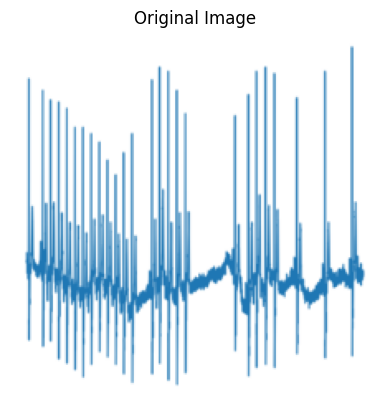

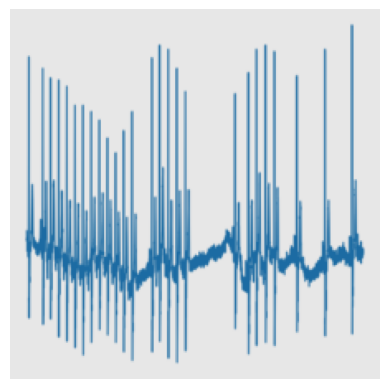

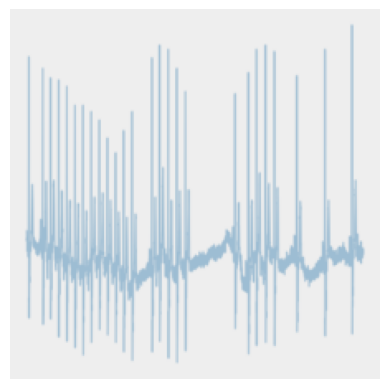

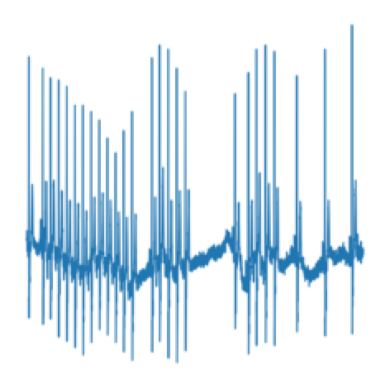

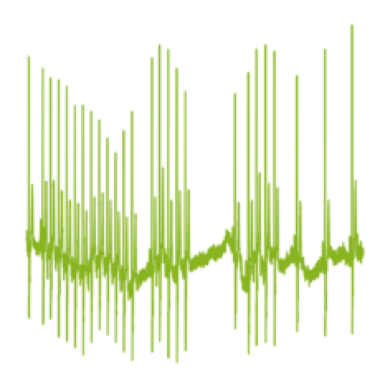

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Function to display image
def show_image(img, title=None):
    plt.figure()
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Load and resize the image
image_path = '232_56.png'  # Replace with the path to your image
original_image = Image.open(image_path)
resize_transform = transforms.Resize((224, 224))
resized_image = resize_transform(original_image)

# Display the original resized image
show_image(resized_image, title="Original Image")

# Define the transformations
brightness_transform = transforms.ColorJitter(brightness=0.8)
contrast_transform = transforms.ColorJitter(contrast=0.8)
saturation_transform = transforms.ColorJitter(saturation=0.8)
hue_transform = transforms.ColorJitter(hue=0.5)

# Apply and display each transformation
transformed_image = brightness_transform(resized_image)
show_image(transformed_image, title="")

transformed_image = contrast_transform(resized_image)
show_image(transformed_image, title="")

transformed_image = saturation_transform(resized_image)
show_image(transformed_image, title="")

transformed_image = hue_transform(resized_image)
show_image(transformed_image, title="")


#The Network

In [ ]:
import torch
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

# USE GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224


   # transforms.ColorJitter(
    #    brightness=0.1,  # Slight change in brightness
    #    contrast=0.1,    # Slight change in contrast
    #    saturation=0.1,  # Slight change in saturation
    #    hue=0.05        # Slight change in hue
    #),


    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])


#I don't know if we want to try augmentation?
#Not sure if it makes sense here, but we COULD Do color augmentation (UNcomment)



# Create the dataset

dataset = ImageFolder(root='/content/input_data/', transform=transform)


# Check the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Load the pretrained RegNet model using the best one i found on their website
regnet = models.regnet_x_400mf(weights=models.RegNet_X_400MF_Weights.IMAGENET1K_V1)

# Delete Last Layer of RegNet and add our own
class RegNetFC(nn.Module):
    def __init__(self, regnet):
        super(RegNetFC, self).__init__()
        self.regnet = nn.Sequential(*list(regnet.children())[:-1])  # Remove the last fc layer
        num_features = regnet.fc.in_features
        self.fc1 = nn.Linear(num_features, 256)  # New FC layer with 256 units
        self.fc2 = nn.Linear(256, 3)  # Final layer matching the number of classes 3
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.regnet(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor to [32, 400]
        x = self.relu(self.fc1(x)) # now it is [32, 256]
        x = self.fc2(x) # now it is just the 3 classes
        return x

# the new model (RegNet + FC)
regnet_fc = RegNetFC(regnet)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(regnet_fc.parameters(), lr=0.001, weight_decay = 1e-4) #Weight decay is regularization

# Move the model to the appropriate device
regnet_fc.to(device)

# Print the model summary
from torchinfo import summary
summary(regnet_fc, input_size=(batch_size, 3, 224, 224))


Training set size: 420
Validation set size: 90
Test set size: 90


Layer (type:depth-idx)                                       Output Shape              Param #
RegNetFC                                                     [32, 3]                   --
├─Sequential: 1-1                                            [32, 400, 1, 1]           --
│    └─SimpleStemIN: 2-1                                     [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                      [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                                 [32, 32, 112, 112]        64
│    │    └─ReLU: 3-3                                        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                       [32, 400, 7, 7]           --
│    │    └─AnyStage: 3-4                                    [32, 32, 56, 56]          7,936
│    │    └─AnyStage: 3-5                                    [32, 64, 28, 28]          35,712
│    │    └─AnyStage: 3-6                                    [32, 160, 14, 14]         

In [ ]:
class EarlyStopping:
    """Early stopping to stop the training when the loss does not improve after
    a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
# early stopping
early_stopping = EarlyStopping(patience=2, verbose=True)

# Training loop
num_epochs = 10  # You can change this as needed


# Define the K-fold Cross Validator
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
  # Define the sizes for training, validation, and test sets
  train_size = int(0.7 * len(dataset))  # 70% training
  val_size = int(0.15 * len(dataset))   # 15% validation
  test_size = len(dataset) - train_size - val_size  # 15% test

  # Split the dataset
  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

  # Create the DataLoaders
  batch_size = 30
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  # Lists to store loss and accuracy
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(num_epochs):
      regnet_fc.train()
      running_loss = 0.0
      correct = 0
      total = 0
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = regnet_fc(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      epoch_loss = running_loss / len(train_loader.dataset)
      train_accuracy = 100 * correct / total
      train_losses.append(epoch_loss)
      train_accuracies.append(train_accuracy)
      print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

      # Validation loop
      regnet_fc.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = regnet_fc(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * inputs.size(0)

              _, predicted = torch.max(outputs, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      val_loss /= len(val_loader.dataset)
      val_accuracy = 100 * correct / total
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

      early_stopping(val_loss, regnet_fc)

      if early_stopping.early_stop:
          print("Early stopping")
          break

  # resets counter for next fold
  early_stopping.counter = 0
  early_stopping.early_stop = False
  results[fold] = {
        'train_loss': epoch_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }


print('Training complete')
# Print fold results
print('K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS')
print('--------------------------------')
for key, value in results.items():
    print(f'Fold {key}: {value}')

# Average performance across all folds
avg_val_accuracy = np.mean([results[fold]['val_accuracy'] for fold in range(k_folds)])
print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}')



Epoch 1/10, Training Loss: 0.0576, Training Accuracy: 98.57%
Validation Loss: 0.5030, Validation Accuracy: 88.89%
Validation loss decreased (inf --> 0.503015).  Saving model ...
Epoch 2/10, Training Loss: 0.0527, Training Accuracy: 97.86%
Validation Loss: 0.1236, Validation Accuracy: 96.67%
Validation loss decreased (0.503015 --> 0.123578).  Saving model ...
Epoch 3/10, Training Loss: 0.0457, Training Accuracy: 98.57%
Validation Loss: 0.1199, Validation Accuracy: 94.44%
Validation loss decreased (0.123578 --> 0.119946).  Saving model ...
Epoch 4/10, Training Loss: 0.0243, Training Accuracy: 99.76%
Validation Loss: 0.2155, Validation Accuracy: 94.44%
EarlyStopping counter: 1 out of 2
Epoch 5/10, Training Loss: 0.0114, Training Accuracy: 99.52%
Validation Loss: 0.0119, Validation Accuracy: 100.00%
Validation loss decreased (0.119946 --> 0.011862).  Saving model ...
Epoch 6/10, Training Loss: 0.0676, Training Accuracy: 98.33%
Validation Loss: 0.7859, Validation Accuracy: 88.89%
EarlyStopp

In [ ]:
np.std([results[fold]['val_accuracy'] for fold in range(k_folds)])

7.793634629666749

In [ ]:
early_stopping.counter = 0

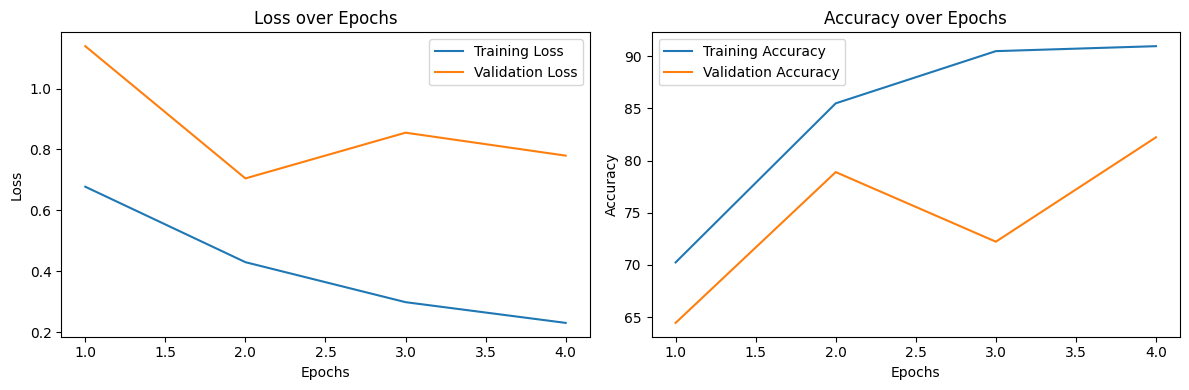

In [ ]:
# Plotting the results
epochs = range(1, 4 + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np


regnet_fc.load_state_dict(torch.load('checkpoint.pt'))

# Testing loop
regnet_fc.eval()
test_loss = 0.0
all_labels = []
all_predictions = []
all_probabilities = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = regnet_fc(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(outputs.softmax(dim=1).cpu().numpy())

test_loss /= len(test_loader.dataset)
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
test_accuracy = np.sum(all_predictions == all_labels) / len(all_labels)
test_f1_score = f1_score(all_labels, all_predictions, average='weighted')
test_precision = precision_score(all_labels, all_predictions, average='weighted')
test_recall = recall_score(all_labels, all_predictions, average='weighted')
# Calculate AUC for each class and average it (macro)
test_auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr', average='macro')
test_confusion_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"AUC: {test_auc:.4f}")
print("Confusion Matrix:")
print(test_confusion_matrix)

Test Loss: 0.7194
Test Accuracy: 0.7444
F1 Score: 0.7323
Precision: 0.8079
Recall: 0.7444
AUC: 0.9232
Confusion Matrix:
[[19  3  0]
 [ 3 33  0]
 [ 2 15 15]]


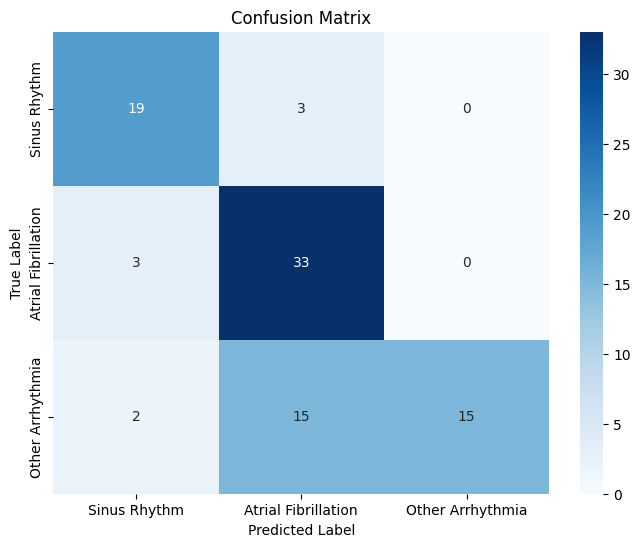

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming `all_labels` and `all_predictions` are your true and predicted labels respectively

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sinus Rhythm', 'Atrial Fibrillation', 'Other Arrhythmia'], yticklabels=['Sinus Rhythm', 'Atrial Fibrillation', 'Other Arrhythmia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
